# Glade vs. Stratus Performance for NA-CORDEX Zarr Stores

The [NA-CORDEX Visualization Cookbook](https://github.com/ProjectPythia/na-cordex-viz-cookbook/blob/main/notebooks/plot-diagnostics.ipynb) loads data from either NCAR's Glade filesystem or the Stratus Object Store.  We are interested in knowing more about how Glade and Stratus perform relative to each other when the notebook is run.   **Because the notebook includes a significant computational component, the apparent performance difference between using Glade and Stratus will be reduced, as compared to a notebook that simply loads the data from disk.**

In order to make sense of the comparison, we need to know a little more about the following:

* The Notebook's access patterns
* Data organization within NA-CORDEX Zarr Stores

Then we show some running time comparisons and one possible interpretation of the results.

**Important**:  These results were obtained on NCAR's JupyterHub server using the Casper node cluster.  The network bandwidth on Casper can be shared across users, which can have a large influence on performance results.  For those interested in minimizing these potential impacts, a final section shows how to allocate an isolated node on Casper where network bandwidth is not shared with other users.  The strategy works, provided that Casper's job queue is not over-prescribed with allocation requests.  **However**, the results presented here did not use an isolated node.   During normal working hours, it  currently seems next to impossible to allocate a separate node; the casper job queue is often full of smaller requests that get handled first. It would be necessary to try allocating a node during off-peak hours and re-run the comparisons.

The Casper architecture is described in detail [on this NCAR documentation site](https://arc.ucar.edu/knowledge_base/70549550).

## Notebook Access Patterns

The notebook loops over climate runs and focuses on producing plots for a single climate run at a time.   This pattern is not the most efficient because a chunk file usually contains four climate runs.  More specifically, the notebook loads chunk files containing data from four climate runs, but only one of those runs is selected for plotting at one time.   The data from the other three climate runs in the chunk files are loaded and discarded.  This pattern repeats itself four times when producing plots for four climate runs.  While we could change the notebook to hold all four climate runs in memory once they are loaded, this would in practice mean that Dask workers would need more than 40 GB of RAM each to handle plotting the largest of the Zarr stores.   Writing the notebook to allocate this much memory seemed less portable and more contentious to run on a multi-user system than requiring a smaller amount of RAM per worker, and reloading data values repeatedly.


The Visualization Cookbook produces three types of plots, each of which requires loading a portion of data from a Zarr store.   Below are the three types of the plots, with lists of the operations that require a __complete pass__ through the output for a model run:


#### Plot First, Mid, Last Timesteps: __One Complete Pass__

This plot requires one complete pass through a climate run's output:

* Find time steps with valid data in any grid cell

Then it searches for min and max values across all grid cells within the first, middle, and final valid timesteps, but this cost is negligible compared to a complete pass through the data.

![test](./tmax.day.eval.NAM-44i.raw_FML.png)


#### Produce Statistical Map Plot: __Four Complete Passes__

This plot requires four complete passes through the data:

* Find smallest value per grid cell over all timesteps
* Find largest value per grid cell over all timesteps 
* Find mean value per grid cell over all timesteps 
* Find standard deviation value per grid cell over all timesteps 

Then it searches for min and max values within the produced results, but this cost is negligible compared to a complete pass through the data.

![test](./tmax.day.eval.NAM-44i.raw_MAPS.png)


#### Produce Statistical Time Series Plot: __Five Complete Passes__

This plot requires five complete passes through the data:

* Find time steps with missing data for all grid cells
* Find smallest value per time step for all grid cells
* Find largest value per time step for all grid cells 
* Find mean value per time step for all grid cells
* Find standard deviation value per time step for all grid cells

![test](./tmax.day.eval.NAM-44i.raw_TS.png)

## Data organization within NA-CORDEX Zarr Stores

Each Zarr store aggregates data, over many model runs, for one output variable over a specific climate scenario or historical period.  

Zarr stores are organized as 4D data cubes broken into smaller, 4D chunk files.  Each chunk file, except those on the ragged edges of the data cube, have data for:

* 1000 daily timesteps
* 65   latitude values
* 120  longitude values
* 4    model runs

for around 31 million floating point values per chunk file.   So a chunk file, uncompressed, should require around 120 MB of space to reside in memory.

More complete documentation for the NA-CORDEX variables and scenarios can be found at the [NA-CORDEX documentation site](https://doi.org/10.26024/9xkm-fp81).

### Example dataset:  Precipitation from 1980-2015

![test](./images/chunk_description.png)

### Compression characteristics

Each chunk file is compressed using Blosc compression.   Below is a histogram showing chunk file sizes for Precipitation after compression.   Compression levels seem similar for other variables besides Precipitation.

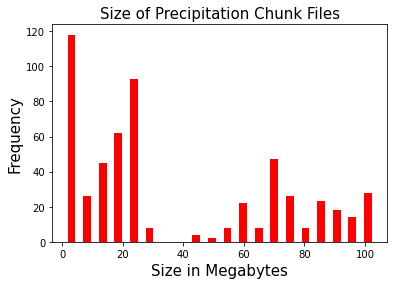

In [36]:
import numpy as np
from matplotlib import pyplot as plt

f = open('./data/sizes.prec.eval.NAM-22i.txt','r')
x = np.loadtxt(f)
x = x / 1000000.0
plt.hist(x, bins=20, histtype='bar',facecolor = 'red',  rwidth=0.5)
plt.xlabel('Size in Megabytes',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Size of Precipitation Chunk Files',fontsize=15)
plt.show()

## Running Time Analysis

Below we plot the ratio of completion times for each type of plot.   In general, Stratus as a storage device is slower than Glade, so we produced the ratio: 

    (Stratus completion time) / (Glade completion time)
    
and plotted this ratio for different Zarr stores and numbers of Dask workers.

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def make_plot(ratios, scenario):
    figWidth = 18 
    figHeight = 12 

    fig = plt.figure(figsize=(figWidth, figHeight))
    nWorkers = [4, 8, 16, 32]
    plt.plot(nWorkers,ratios[0],'x-', label='low compute')
    plt.plot(nWorkers,ratios[1],'+-', label='med compute')
    plt.plot(nWorkers,ratios[2],'o-', label='high compute')
    plt.xlabel('Number of Workers')
    plt.ylabel('(Stratus time) / (Glade time)')
    plt.title(f'Time to Completion Ratio for "{scenario}" scenario')
    plt.legend(loc='best')
    return fig

In [39]:
comparison = dict(stratus = [], glade = [])

In [78]:
data = dict(eval = comparison, hist = comparison, 
            rcp85 = comparison)


### Running times for "eval" scenario (35 years)

Each 2D array of numbers contains running times in elapsed seconds.  
Each row represents a different plot type, and each column represents a different numbers of workers (4, 8, 16, or 32 workers).

In [87]:
data['eval']['stratus'] = [[228, 111, 71, 47], 
                           [351,100,54,49.9],
                           [523,221,116,64]]

In [88]:
data['eval']['glade'] = [[73,43.5,30.2,20.8], 
                           [182,60,31,34.8],
                           [291,163,92,50.7]]

In [89]:
# Perform element-wise division
ratios = np.divide(data['eval']['stratus'], data['eval']['glade'])
ratios

array([[3.12328767, 2.55172414, 2.35099338, 2.25961538],
       [1.92857143, 1.66666667, 1.74193548, 1.43390805],
       [1.79725086, 1.35582822, 1.26086957, 1.26232742]])

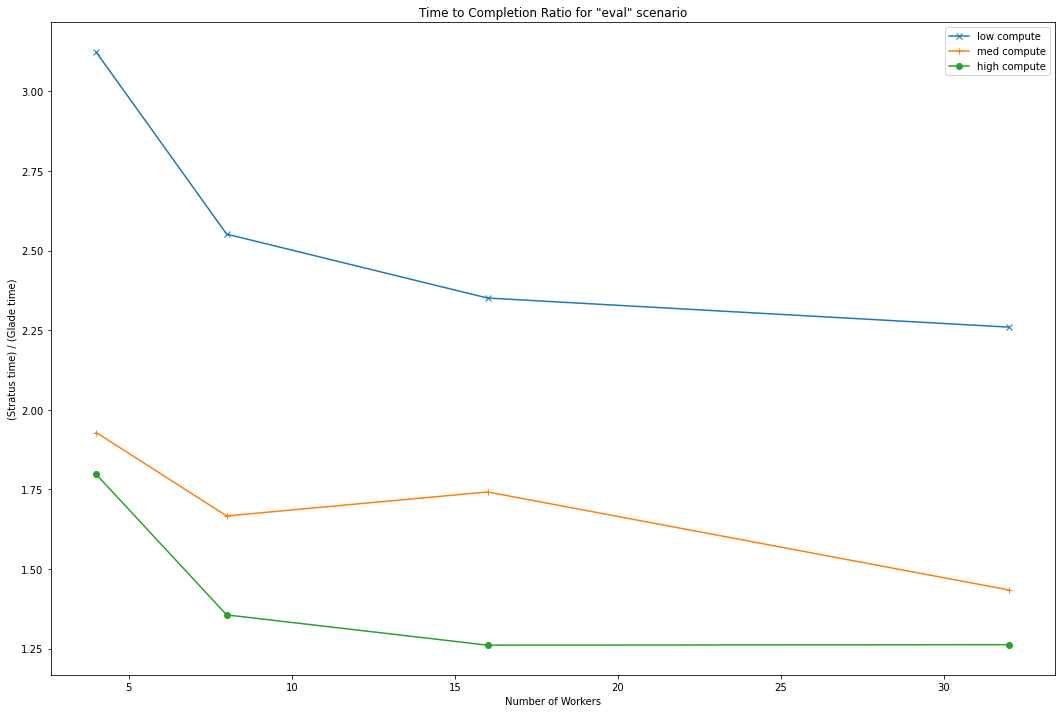

In [90]:
figure = make_plot(ratios, 'eval')
plt.show()

### Running times for "hist" scenario (50 years)
Each 2D array of numbers contains running times in elapsed seconds.  
Each row represents a different plot type, and each column represents a different numbers of workers (4, 8, 16, or 32 workers).

In [91]:
data['hist']['stratus'] = [[387,172,111,64], 
                           [592,254,137,77],
                           [890,352,187,102]]

In [92]:
data['hist']['glade'] = [[107, 62, 37.1, 22.9], 
                         [278, 167, 90, 52.2],
                         [460, 264, 138, 74]]

In [93]:
# Perform element-wise division
ratios = np.divide(data['hist']['stratus'], data['hist']['glade'])
ratios

array([[3.61682243, 2.77419355, 2.99191375, 2.79475983],
       [2.1294964 , 1.52095808, 1.52222222, 1.47509579],
       [1.93478261, 1.33333333, 1.35507246, 1.37837838]])

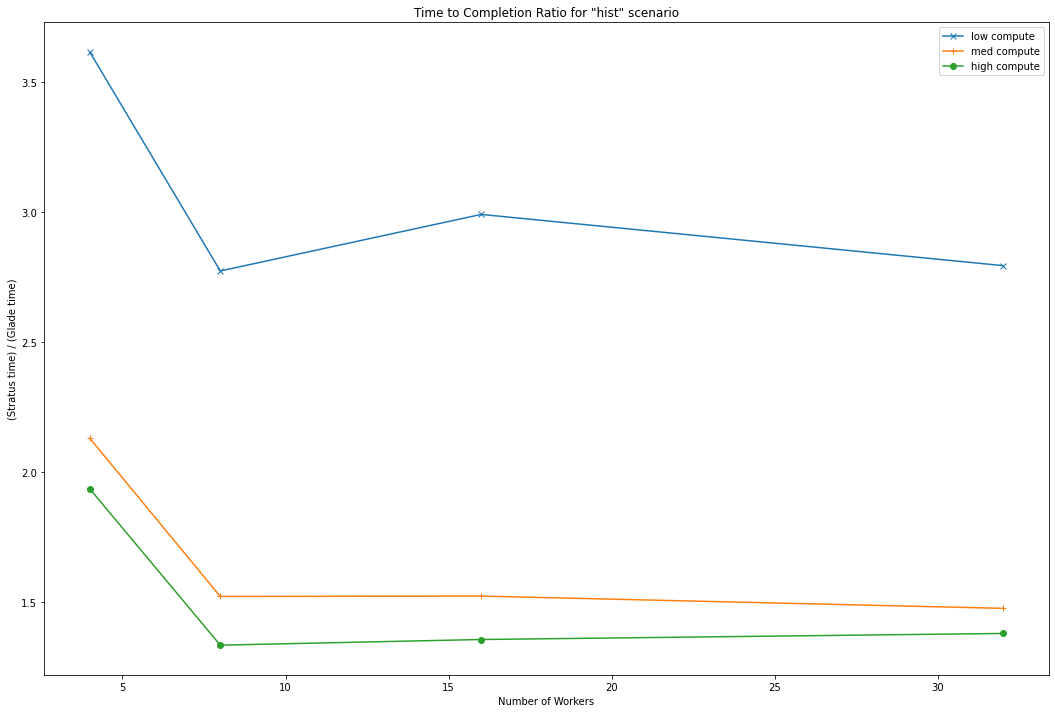

In [94]:
figure = make_plot(ratios, 'hist')
plt.show()

### Running times for "rcp85" scenario (100 years)
Each 2D array of numbers contains running times in elapsed seconds.  
Each row represents a different plot type, and each column represents a different numbers of workers (4, 8, 16, or 32 workers).

In [95]:
data['rcp85']['stratus'] = [[504,260,159,90], 
                           [819,416,231,126],
                           [1222,609,339,168]]

In [96]:
data['rcp85']['glade'] = [[161, 90, 53.7, 32.4], 
                           [467,258,146,72],
                           [773,466,239, 128]]

In [97]:
# Perform element-wise division
ratios = np.divide(data['rcp85']['stratus'], data['rcp85']['glade'])
ratios

array([[3.13043478, 2.88888889, 2.96089385, 2.77777778],
       [1.75374732, 1.6124031 , 1.58219178, 1.75      ],
       [1.58085382, 1.30686695, 1.41841004, 1.3125    ]])

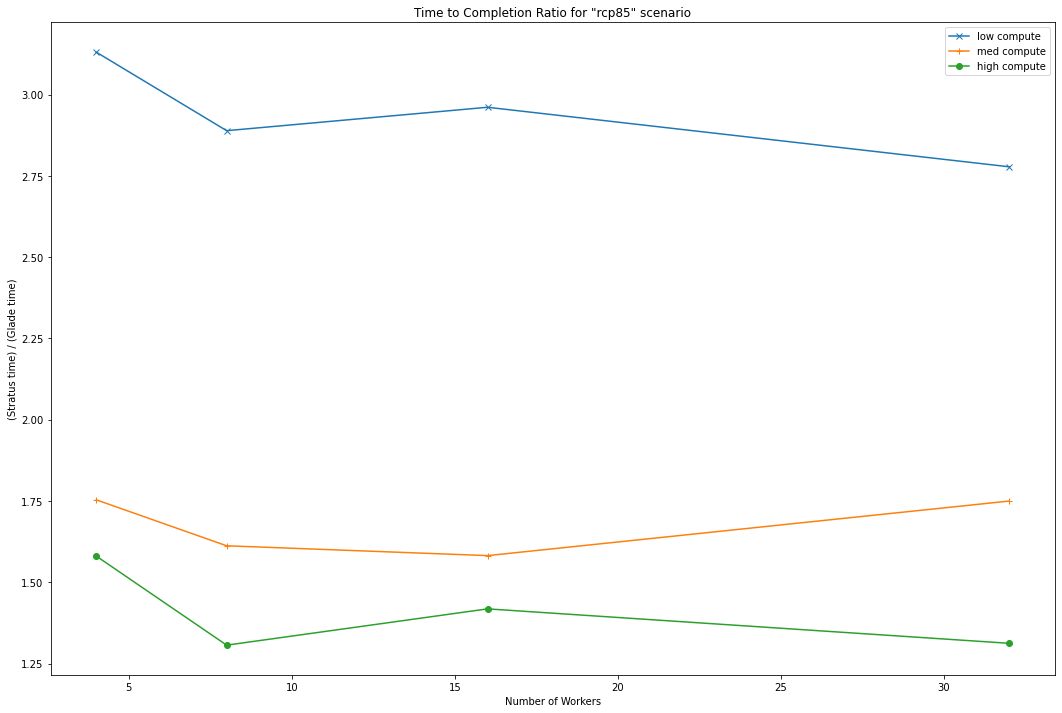

In [98]:
figure = make_plot(ratios, 'rcp85')
plt.show()

### Running times for "hist-rcp85" scenario (150 years)
Each 2D array of numbers contains running times in elapsed seconds.  
Each row represents a different plot type, and each column represents a different numbers of workers (4, 8, 16, or 32 workers).

In [71]:
data['hist-rcp85'] = {}

In [72]:
data['hist-rcp85']['stratus'] = [[736, 412, 209, 120], 
                           [1163,636,355,189],
                           [1665,931,519,263]]

In [73]:
data['hist-rcp85']['glade'] = [[315, 197, 68, 41], 
                           [709,479,228,125],
                           [1219,819,381,199]]

In [74]:
# See if element-wise division is supported
ratios = np.divide(data['hist-rcp85']['stratus'], data['hist-rcp85']['glade'])
ratios

array([[2.33650794, 2.09137056, 3.07352941, 2.92682927],
       [1.6403385 , 1.32776618, 1.55701754, 1.512     ],
       [1.36587367, 1.13675214, 1.36220472, 1.32160804]])

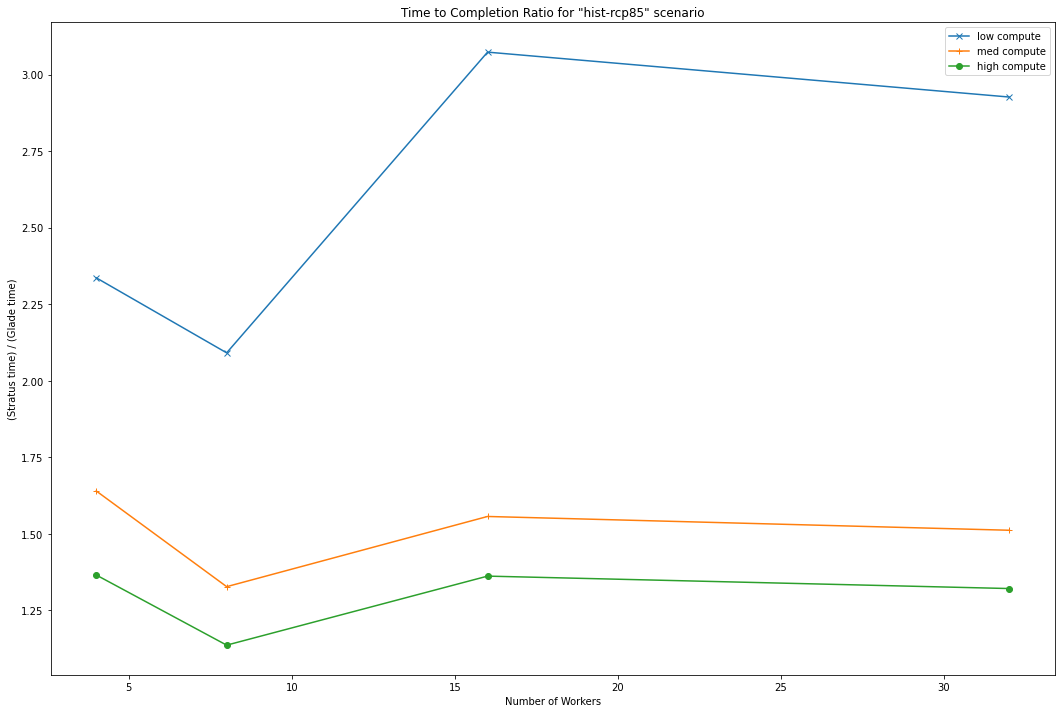

In [75]:
figure = make_plot(ratios, 'hist-rcp85')
plt.show()

## How to Allocate an Isolated Casper Node

Because Casper nodes are typically shared across users, resource contention for network bandwidth is a potential concern.    The simplest way around this is to allocate an isolated node from Casper.   However, it can be difficult to obtain an entire node when Casper's resources are in heavy demand.   Smaller requests are given priority, and requests for an entire node may time out before being fulfilled.

First, select "Add New Server" on the JupyterHub home page (https://jupyterhub.hpc.ucar.edu/stable/hub/home).   Then fill out these items accordingly, substituting a usable account code in place of the one used here (STDD0003):


![test](./images/casper_alloc.png)

Then, in the cookbook, set `USE_PBS_SCHEDULER = False` and `USE_DASK_GATEWAY = False`.    This will cause Dask Workers to be obtained using Dask's `LocalCluster` resource allocator.   `LocalCluster` will use resources from the isolated node that was originally allocated through the request form above, rather than make another request for Dask workers from some other Casper node.   

## Conclusions

The running time results suggest the following:

* For simple computations where data loading time dominates, Glade is around 3x faster than Stratus.
* As the computational costs increase, data loading time has less impact, so the difference between using Glade or Stratus decreases toward equal running times regardless of storage device.
* Increasing the number of workers always makes the notebook run more quickly, but the performance difference between Glade and Stratus also changes in a small but significant way.   

It's unclear why Glade vs. Stratus performance ratios changes with the number of workers.  It could be something like the interprocess communication patterns between workers are unpredictable for different numbers of workers.   It could also be natural variations in disk load on a production system like Casper.   We also did not try to concentrate workers on single Casper nodes, so variations could be due to communication overhead differences for different worker configurations.   Ideally, running times should be obtained on an isolated Casper node to remove potential variability from multiple users contending for network bandwidth on a single node.